### Import Libraries

In [4]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt
import pickle
import os
from scipy.stats import boxcox
from pandas import DataFrame
from matplotlib import pyplot

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from itertools import chain

### Define classes and functions for trading simulation

In [5]:
from enum import Enum
class PositionType(Enum):
    BUY = 1
    SHORT = 2
    
"""
Position / action class
"""


class Position:
    def __init__(self, position_type, amount):
        self.type = position_type
        self.amount = amount


"""
Plots two time series side-by-side
"""


def plot_time_series(ts_1, ts_label_1, ts_2, ts_label_2, title):
    assert len(ts_1) == len(ts_2)
    xs = list(range(0, len(ts_1)))

#     plt.plot(xs, ts_1, c='green', label=ts_label_1)
#     plt.plot(xs, ts_2, c='red', label=ts_label_2)
    plt.plot(xs, ts_1, color = "green", marker="o", markersize=5, linestyle = 'None', label=ts_label_1)
    plt.plot(xs, ts_2, color = "red", marker="o", markersize=5, linestyle = 'None', label=ts_label_2)
    

    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()
    
"""
Plots a visualization of balance over time after completion of a
a series of trades simulation
"""


def plot_balance(data):
    xs = list(range(0, len(data)))  # create an x axis

    plt.plot(xs, data, c='green', label='Balance')

    plt.title("balance over time")
    plt.legend(loc='upper left')
    plt.show()


def plot_performance(performance_list):
    x_records = list(range(0, len(performance_list)))  # create an x axis

    plt.plot(x_records, performance_list, c='magenta', label='Performance')

    plt.title("Performance over time")
    plt.legend(loc='upper left')
    plt.show()

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades_returns(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []
    
    # INITIAL BALANCE
    balance = 200
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

### Create dictionaries to store final balances and predictions made by forecasting algorithms

In [6]:
'''
MSFT and AAPL
KO and PEP
Bank of America (BAC) and JPM
Morgan Stanley (MS) and Goldman Sachs (GS) (Correlation coeff = 0.8685)
NVDA and AMD
Mastercard (MA) and Visa (V)
'''
specified_tickers_old = ["NVDA", "PYPL", "XOM", "FB", "GOOGL", "AAPL", "JPM", "KO", "NKE", "AMZN"]
specified_tickers = ['MS','GS', 'MSFT', 'AAPL', 'KO', 'PEP', 'BAC', 'JPM', 'MA','V']

specified_ticker_pairs = [['NVDA','AMD'], ['MSFT', 'AAPL'], ['KO', 'PEP'], ['BAC', 'JPM'], ['MA','V']]

# Initialize a dictionary which will store balances computed after using forecasting algorithms
vanilla_results_no_threshold = {}
for ticker in tqdm(specified_tickers):
    vanilla_results_no_threshold[ticker] = {}
    #vanilla_results[ticker]["lr"] = []
    vanilla_results_no_threshold[ticker]["rfr_ensemble"] = []
    vanilla_results_no_threshold[ticker]["rfr_base"] = []
    vanilla_results_no_threshold[ticker]["ar1"] = []
    #vanilla_results[ticker]["ar1_sp"] = []
    #vanilla_results[ticker]["lr_weights"] = []
    vanilla_results_no_threshold[ticker]["arima"] = []
    #vanilla_results[ticker]["arima_sp"] = []
    #vanilla_results[ticker]["rfr_base_sp"] = []
    vanilla_results_no_threshold[ticker]["theta"] = []
    vanilla_results_no_threshold[ticker]["ar_nn"] = []
    #vanilla_results[ticker]["theta_sp"] = []
    vanilla_results_no_threshold[ticker]["var"] = []
    vanilla_results_no_threshold[ticker]["varma"] = []
    vanilla_results_no_threshold[ticker]["varmax"] = []
    
print(vanilla_results_no_threshold)

# Create dictionary to save predictions for every base method
predictions_no_threshold = {}
for ticker in tqdm(specified_tickers):
    predictions_no_threshold[ticker] = {}
    #vanilla_results[ticker]["lr"] = []
    predictions_no_threshold[ticker]["rfr_ensemble"] = []
    predictions_no_threshold[ticker]["rfr_base"] = []
    predictions_no_threshold[ticker]["ar1"] = []
    #vanilla_results[ticker]["ar1_sp"] = []
    #vanilla_results[ticker]["lr_weights"] = []
    predictions_no_threshold[ticker]["arima"] = []
    #vanilla_results[ticker]["arima_sp"] = []
    #vanilla_results[ticker]["rfr_base_sp"] = []
    predictions_no_threshold[ticker]["theta"] = []
    predictions_no_threshold[ticker]["ar_nn"] = []
    #vanilla_results[ticker]["theta_sp"] = []
    predictions_no_threshold[ticker]["var"] = []
    predictions_no_threshold[ticker]["varma"] = []
    predictions_no_threshold[ticker]["varmax"] = []

100%|██████████| 10/10 [00:00<00:00, 35879.42it/s]

{'MS': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'GS': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'MSFT': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'AAPL': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'KO': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'PEP': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'BAC': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], 'theta': [], 'ar_nn': [], 'var': [], 'varma': [], 'varmax': []}, 'JPM': {'rfr_ensemble': [], 'rfr_base': [], 'ar1': [], 'arima': [], '

### Load dataset

In [7]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

#curPath = "/home/ans682/forecasting"
curPath = os.getcwd()

# Load 5 years of data
all_data = pd.read_pickle(curPath + "/all_oex_5y_data.pkl")

# Store training_data
training_data = pd.read_pickle(curPath + "/training_oex_5y_data.pkl")

# Store test_data
test_data = pd.read_pickle(curPath + "/test_oex_5y_data.pkl")

## VAR algorithm

### Define the invert_transformation function
It will be used in cases when we need to invert the differenced data to the real-life looking values.

In [8]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

### Define adfuller_test to check for stationarity

In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

### Run trading simulation with VAR for 5 pairs of stocks

  0%|          | 0/1 [00:00<?, ?it/s]

Predicting  MS ...
Predicting  GS ...
    Augmented Dickey-Fuller Test on "MS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.9353
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.0416
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




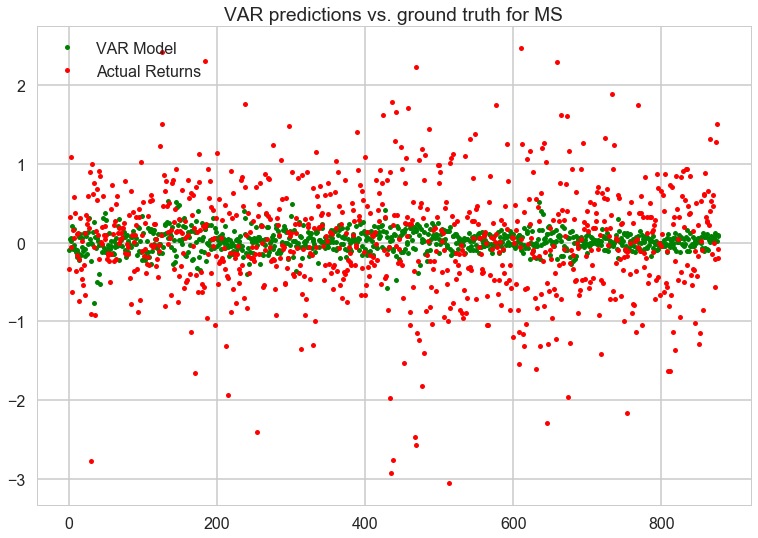

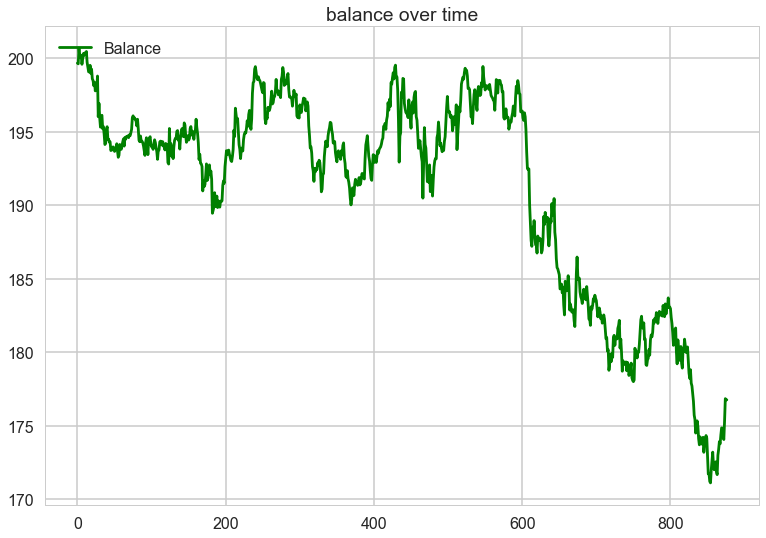

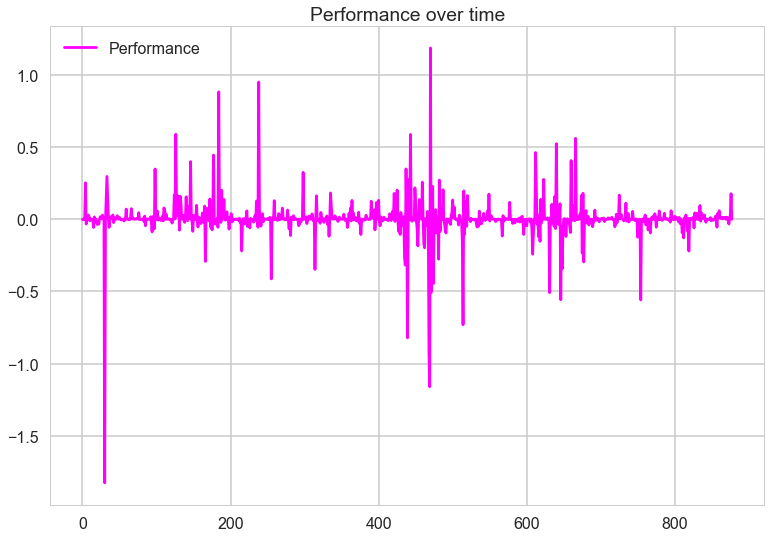

Final balance for  MS :  176.76004791259766


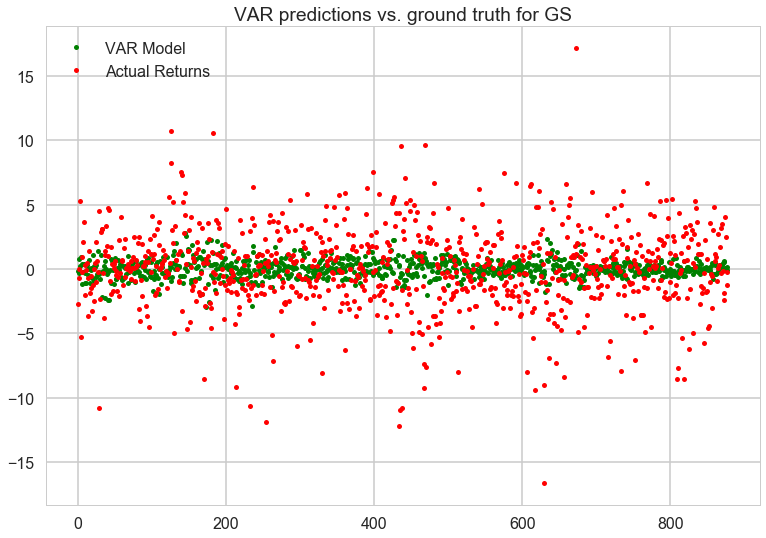

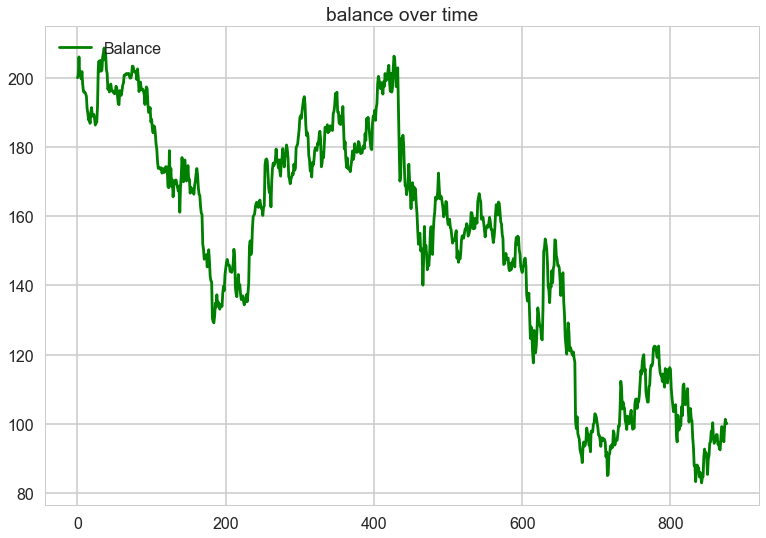

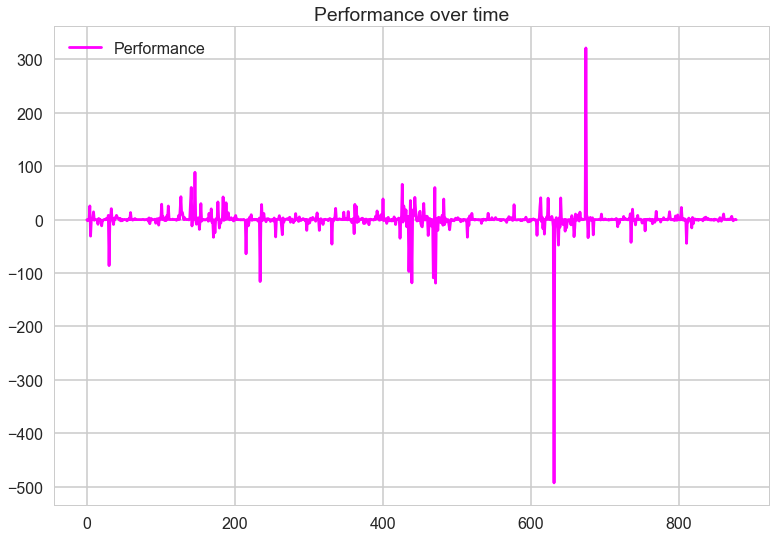


100%|██████████| 1/1 [00:00<00:00, 21732.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Final balance for  GS :  100.05998229980469
Predicting  MSFT ...
Predicting  AAPL ...
    Augmented Dickey-Fuller Test on "MSFT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.7599
 No. Lags Chosen       = 7
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AAPL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3409
 No. Lags Chosen       = 8
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




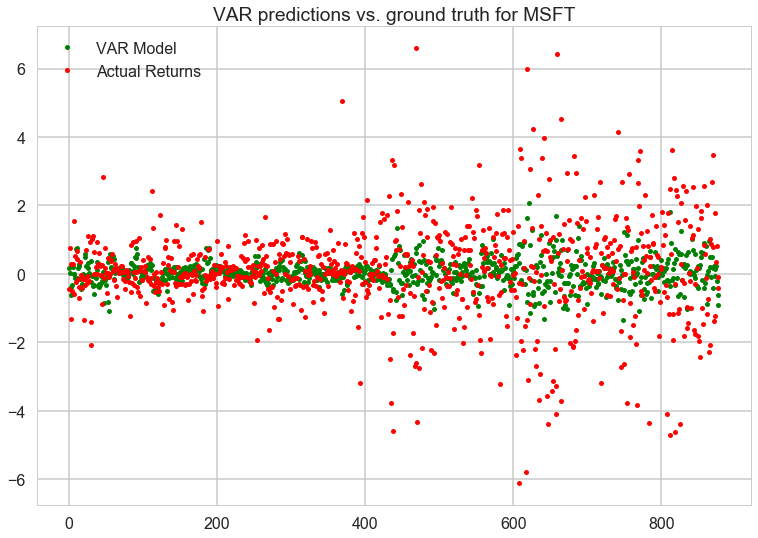

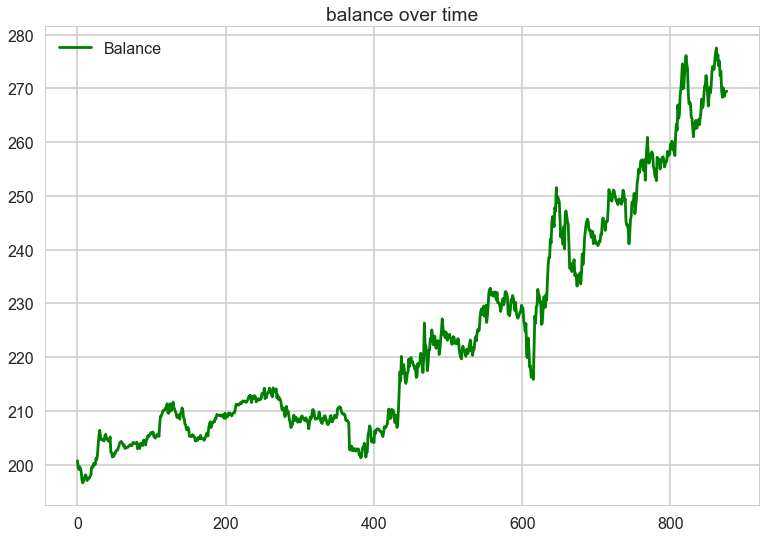

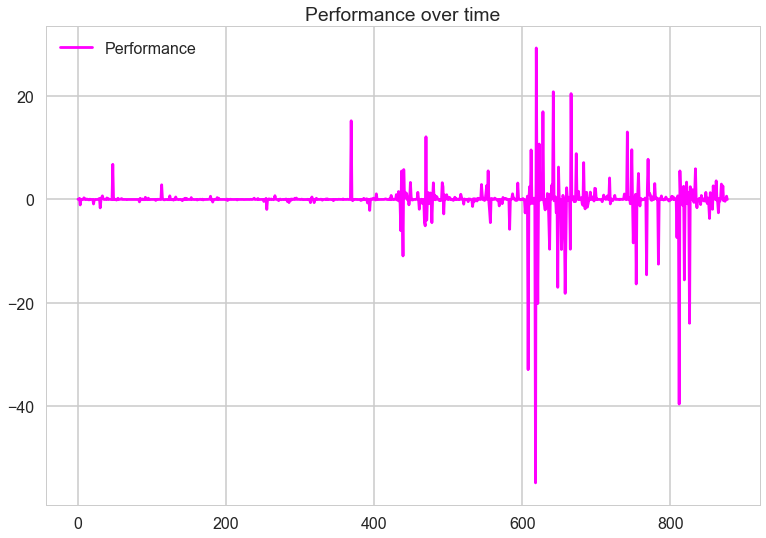

Final balance for  MSFT :  269.43993377685547


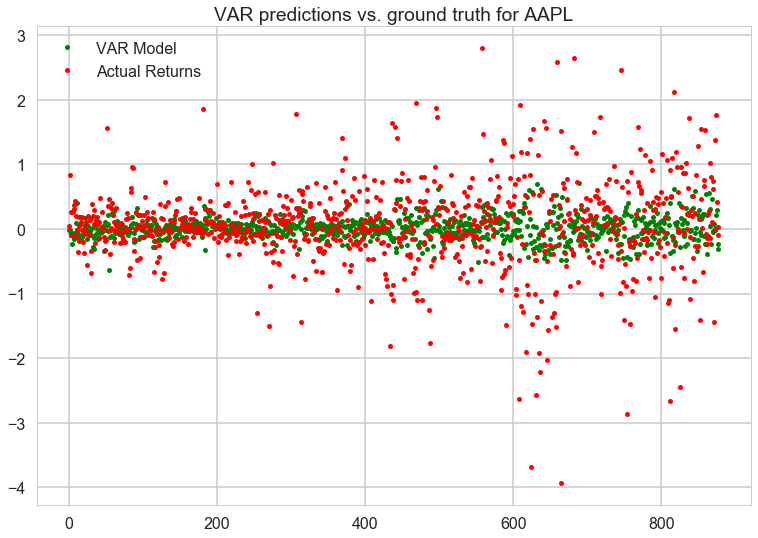

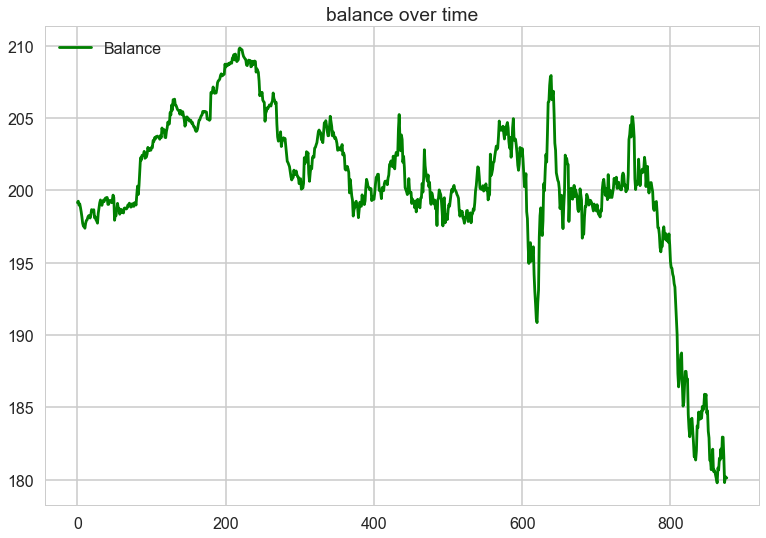

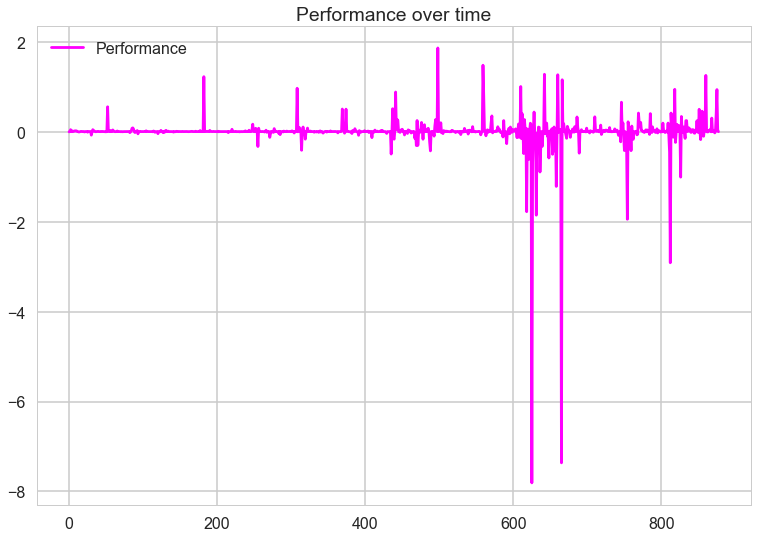


100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Final balance for  AAPL :  180.12742805480957
Predicting  KO ...
Predicting  PEP ...
    Augmented Dickey-Fuller Test on "KO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.0894
 No. Lags Chosen       = 5
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PEP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.5453
 No. Lags Chosen       = 1
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




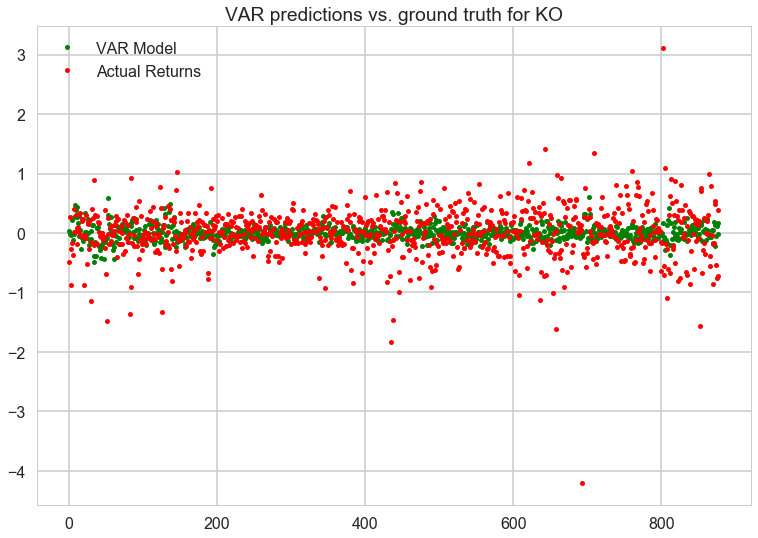

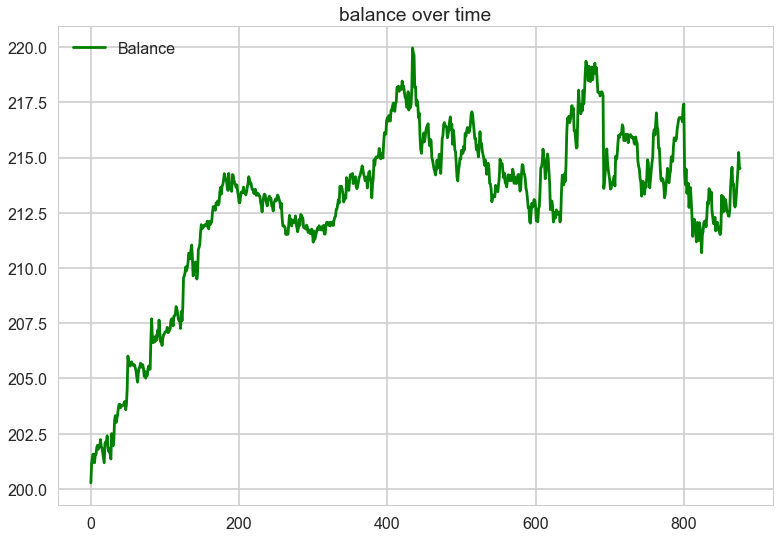

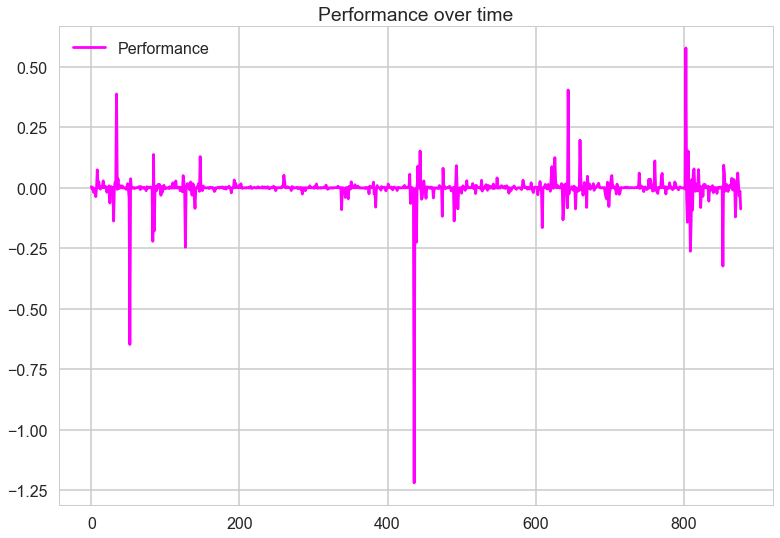

Final balance for  KO :  214.5100326538086


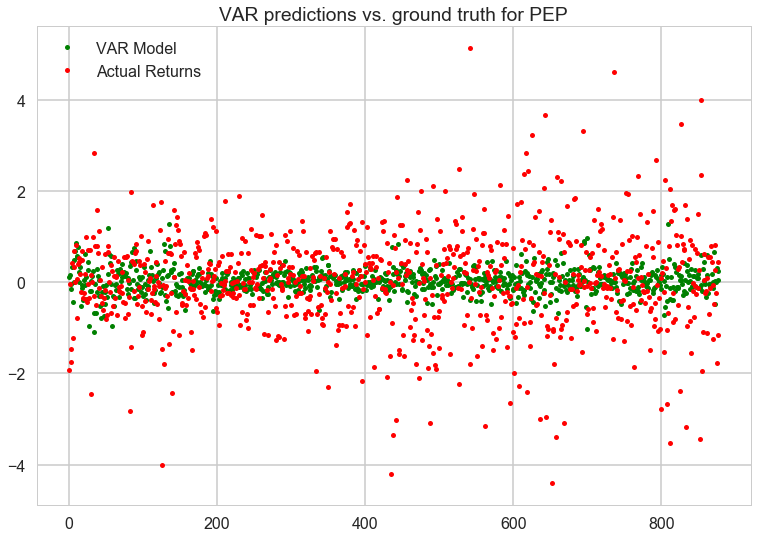

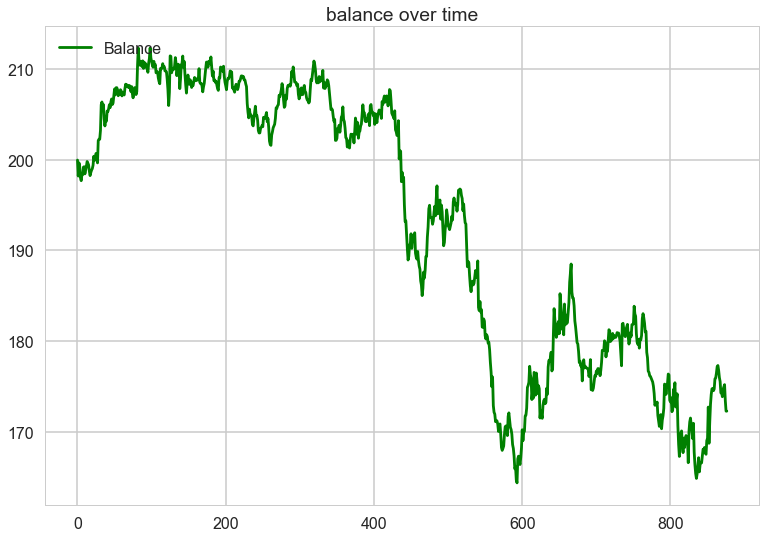

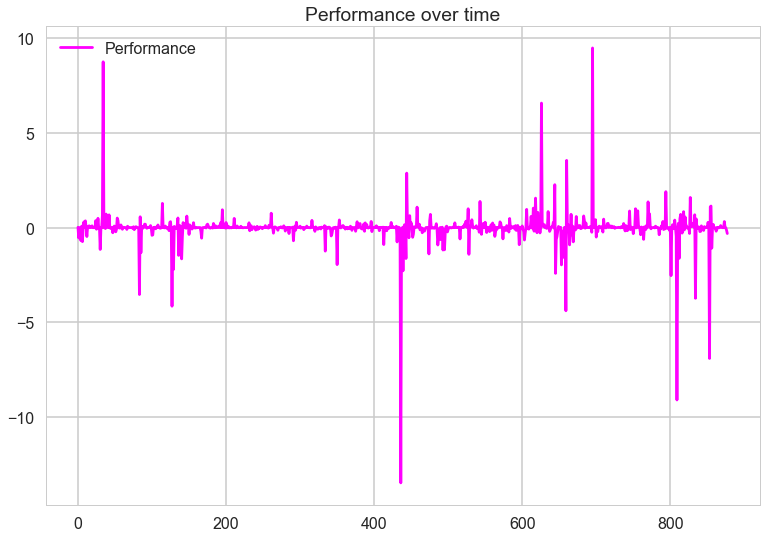


100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Final balance for  PEP :  172.29003143310547
Predicting  BAC ...
Predicting  JPM ...
    Augmented Dickey-Fuller Test on "BAC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -30.6623
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "JPM" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.8953
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




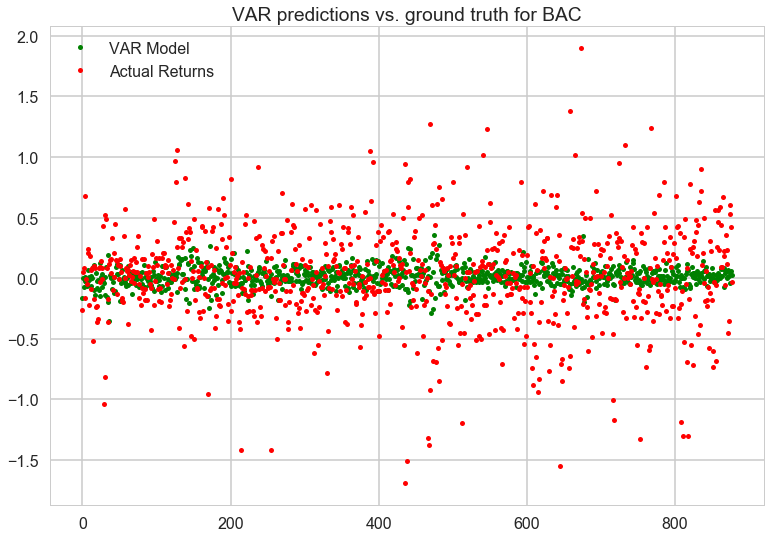

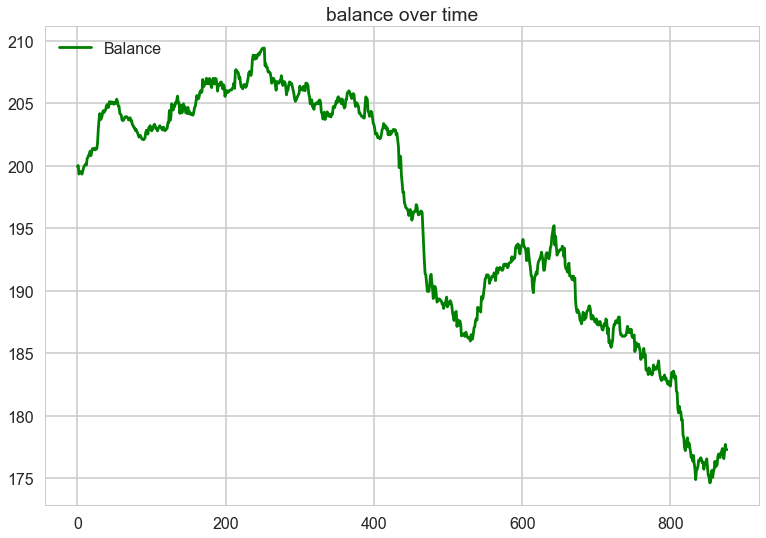

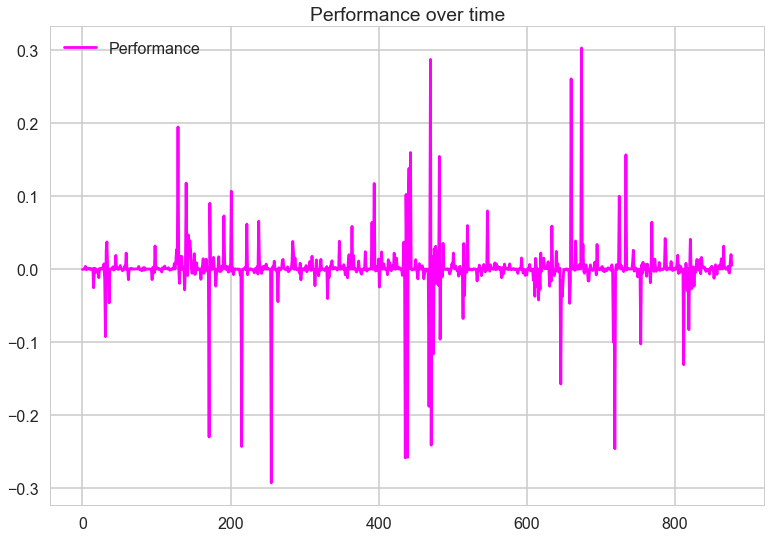

Final balance for  BAC :  177.29999446868896


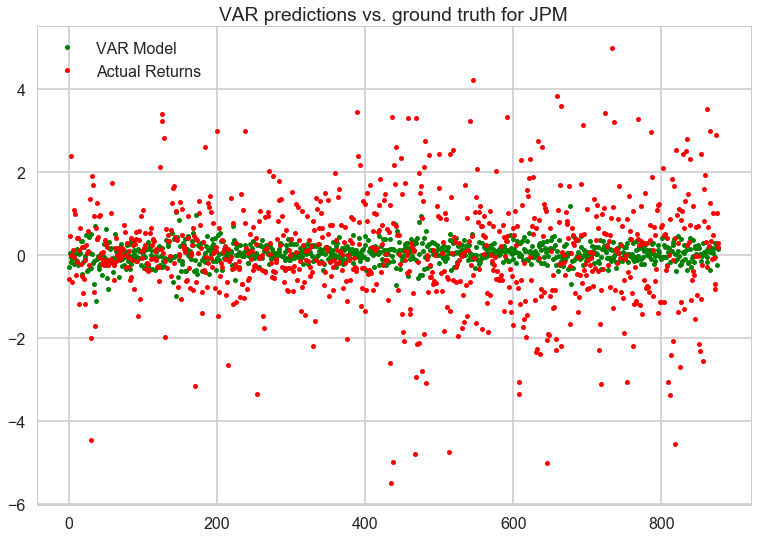

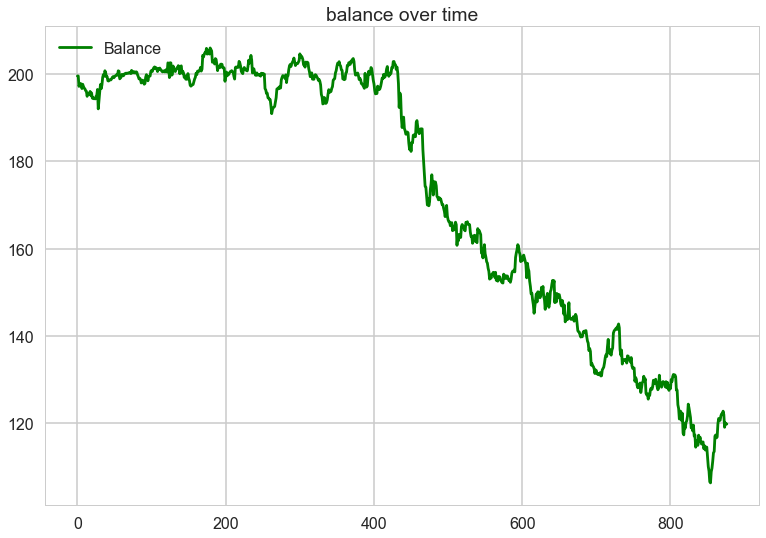

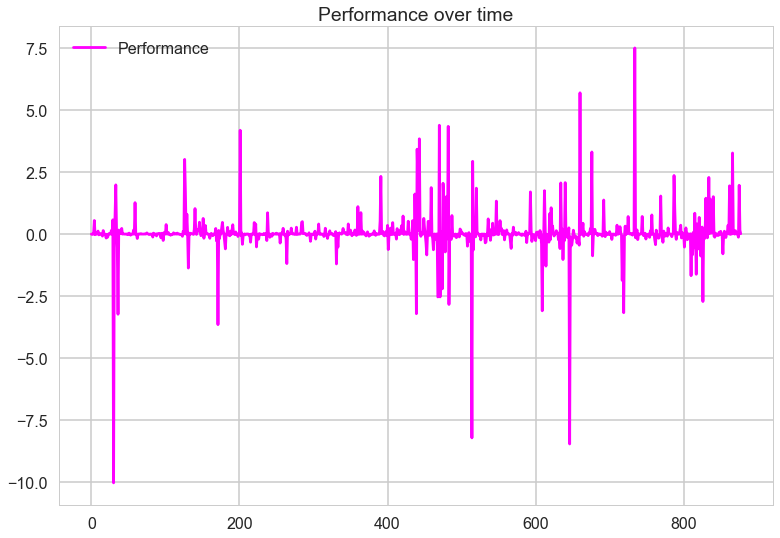


100%|██████████| 1/1 [00:00<00:00, 21290.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Final balance for  JPM :  119.81992721557617
Predicting  MA ...
Predicting  V ...
    Augmented Dickey-Fuller Test on "MA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.8666
 No. Lags Chosen       = 7
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "V" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.7358
 No. Lags Chosen       = 4
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




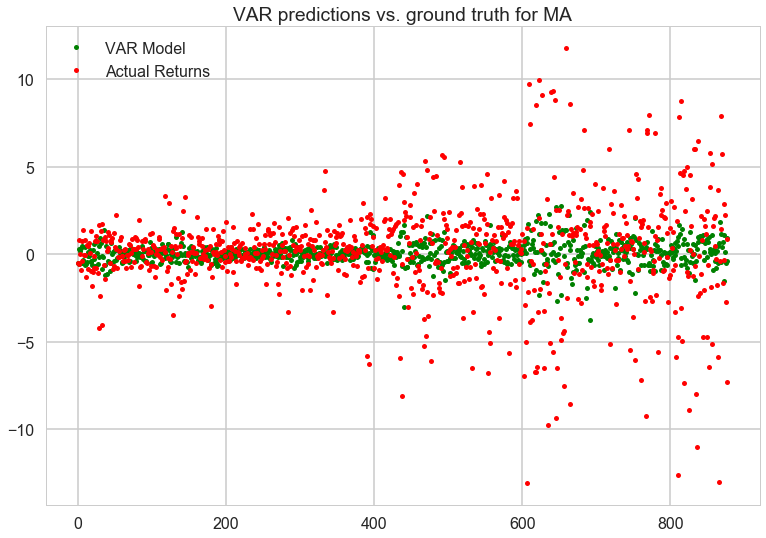

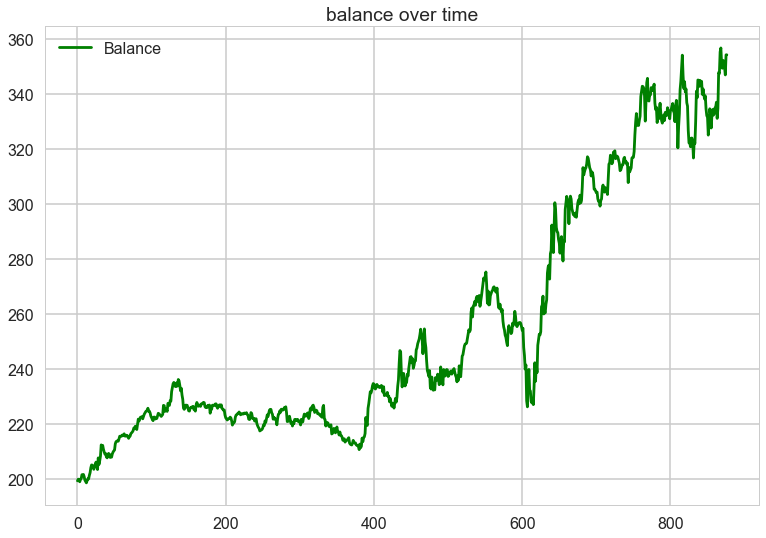

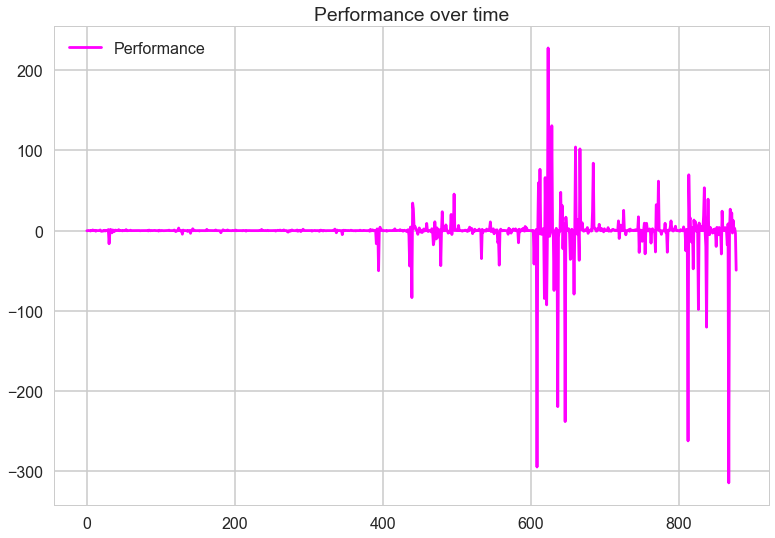

Final balance for  MA :  354.3600769042969


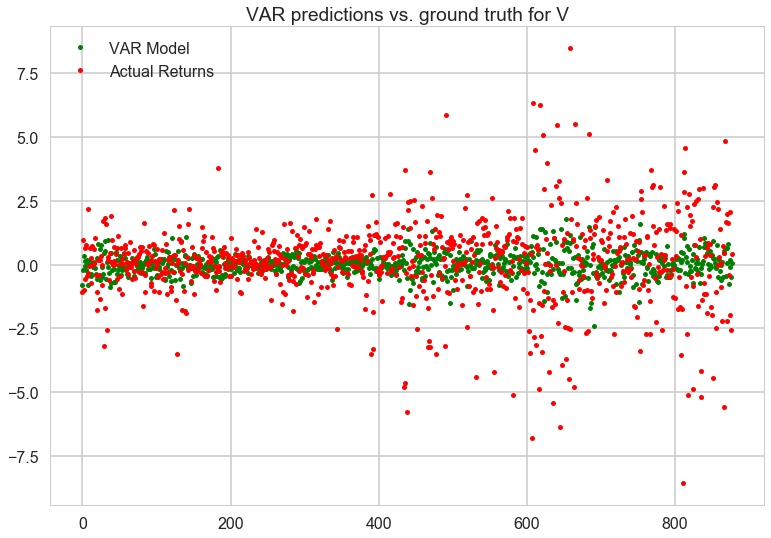

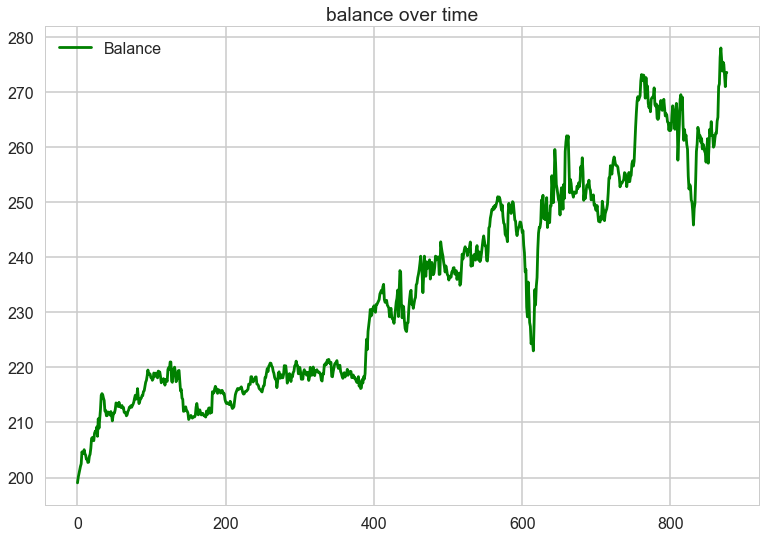

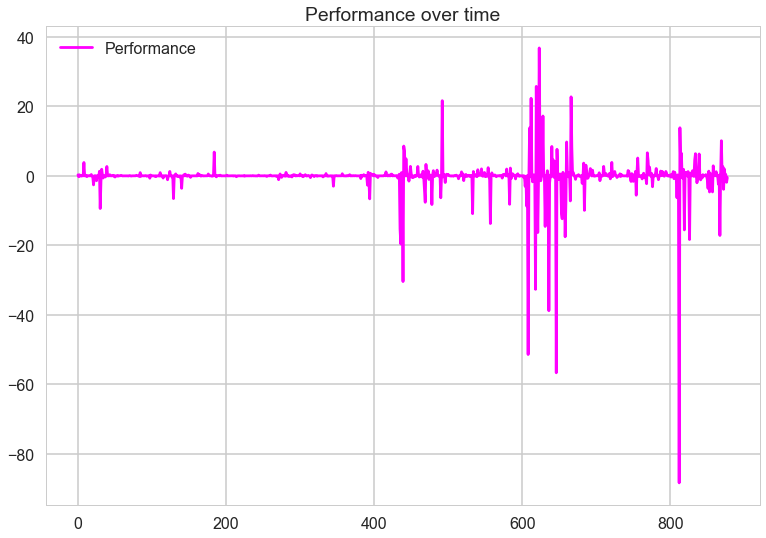


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

Final balance for  V :  273.53997802734375


In [11]:
num_simulations = 1
even_it = 0
for ticker in tqdm(specified_tickers):
    #print(ticker)
    #print("Theta")
    for i in tqdm(range(num_simulations)):
        if even_it % 2 == 0 and even_it <= 8:
            ticker1 = specified_tickers[even_it]
            ticker2 = specified_tickers[even_it + 1]
            
            print("Predicting ", ticker1,"...")
            print("Predicting ", ticker2,"...")
            
            stock1_df = training_data.loc[ticker1].dropna()
            stock2_df = training_data.loc[ticker2].dropna()
            
            # Merge two stocks to one df
            merged_df = pd.concat([stock1_df, stock2_df], axis=1)

            y_past = merged_df[0:merged_df.shape[0]-1] # from [0 : 1004] => Size is 1005
            y_current = merged_df[1:merged_df.shape[0]] # from [1: 1005] => Size is 1005
            # calculate RETURNS: y_current (today) - y_past (yesterday)
            y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True) # Size is 1005

            # store previously calculated returns in x_features. Returns from Day 2 up until Day N - 1.
            x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())}) # Size is 1004

            # now store next day's returns in y_features. y_features store returns from Day 3 up until Day N.
            y_features = y_features[1:y_features.shape[0]].reset_index(drop=True) # Size is 1004



            num_days_year = 253

            # Ground truth values start from Day 2. Today is Day 1.
            ground_truth, start_t = merged_df[1:merged_df.shape[0]-1].to_numpy(), int(num_days_year/2)
            assert len(x_features) == len(y_features)
            predictions_theta_returns = []

            thresholds = []
            base_training_X = x_features[:start_t].reset_index(drop=True)
            base_training_y = y_features[:start_t].reset_index(drop=True)
            base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
            base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

            range_size = len(y_features) - start_t
            # print("Making predictions for ", ticker)
            sign = 1
            performance_list = []


            # Check for stationarity
            for name, column in y_features.iteritems():
                adfuller_test(column, name=column.name)
                print('\n')

            predictions_var_returns = []
            predictions_var_MSFT_returns = []
            predictions_var_AAPL_returns = []
            ground_truth_var_MSFT = []
            ground_truth_var_AAPL = []
            performance_list_MSFT = []
            performance_list_AAPL = []

            for t_i in range(range_size):
                current_t = t_i + start_t
                threshold = 0
                thresholds.append(threshold)

                # Fit increasing orders of VAR model
                model = VAR(y_features[:current_t])


                # Train the VAR model for selected order (p = 10)
                model_fitted = model.fit(10)
                # model_fitted.summary()

                # Forecast VAR model using statsmodels
                lag_order = model_fitted.k_ar
                forecast_input = y_features[:current_t].values[-lag_order:]

                # Forecast
                nobs = 1
                fc = model_fitted.forecast(y=forecast_input, steps=nobs)
                df_forecast = pd.DataFrame(fc, index=merged_df.index[-nobs:], columns=merged_df.columns)
            #     print(df_forecast)
                predictions_var_MSFT_returns.append(df_forecast[ticker1].tolist())
                predictions_var_AAPL_returns.append(df_forecast[ticker2].tolist())

                # Check forecast for MSFT
                if df_forecast[ticker1][0] > 0:
                    sign = 1
                else:
                    sign = -1

                curPerformance = sign*((df_forecast[ticker1][0] * y_features[ticker1][current_t - 1])) * abs(y_features[ticker1][current_t - 1])
                performance_list_MSFT.append(curPerformance)

                # Check forecast for AAPL
                if df_forecast[ticker2][0] > 0:
                    sign = 1
                else:
                    sign = -1

                curPerformance = sign*((df_forecast[ticker2][0] * y_features[ticker2][current_t - 1])) * abs(y_features[ticker2][current_t - 1])
                performance_list_AAPL.append(curPerformance)

                # Invert the transformation to get the real forecast
                # df_results = invert_transformation(y_features[:current_t], df_forecast, second_diff=False)        
                # df_results.loc[:, ['MSFT_forecast', 'AAPL_forecast']]
                # print(df_results)


            # Fill out ground_truth_var_MSFT with MSFT's ground truth values
            for i in range(len(ground_truth)):
                ground_truth_var_MSFT.append(ground_truth[i][0])
                ground_truth_var_AAPL.append(ground_truth[i][1])
                
            # Flatten the prediction returns to a one dimensional list
            predictions_var_MSFT_flat = list(chain.from_iterable(predictions_var_MSFT_returns))

            predictions_var_AAPL_flat = list(chain.from_iterable(predictions_var_AAPL_returns))
            
            # Simulate trades for Stock 1. Save them in balances_var_MSFT
            balances_var_MSFT = simulate_trades_returns(predictions_var_MSFT_flat, ground_truth_var_MSFT[start_t:], thresholds)
            ticker_title = 'VAR predictions vs. ground truth for ' + ticker1
            plot_time_series(ts_1=predictions_var_MSFT_flat, ts_label_1='VAR Model', ts_2=y_features[ticker1].tolist()[start_t:], ts_label_2='Actual Returns', title=ticker_title)

            plot_balance(data=balances_var_MSFT)
            #vanilla_results[ticker]["theta"] = predictions_theta_returns
            plot_performance(performance_list_MSFT)
            print("Final balance for ", ticker1, ": ", balances_var_MSFT[len(balances_var_MSFT)-1])
            
            ######################################################################################
            # Save balances and predictions in dictionaries
            ######################################################################################
            vanilla_results_no_threshold[ticker1]["var"].append(balances_var_MSFT[len(balances_var_MSFT)-1])
            
            
            # Simulate trades for Stock 2. Save them in balances_var_AAPL
            balances_var_AAPL = simulate_trades_returns(predictions_var_AAPL_flat, ground_truth_var_AAPL[start_t:], thresholds)
            ticker_title = 'VAR predictions vs. ground truth for ' + ticker2
            plot_time_series(ts_1=predictions_var_AAPL_flat, ts_label_1='VAR Model', ts_2=y_features[ticker2].tolist()[start_t:], ts_label_2='Actual Returns', title=ticker_title)

            plot_balance(data=balances_var_AAPL)
            #vanilla_results[ticker]["theta"] = predictions_theta_returns
            plot_performance(performance_list_AAPL)
            print("Final balance for ", ticker2, ": ", balances_var_AAPL[len(balances_var_AAPL)-1])
                
            
            # Save balances in dictionaries
            vanilla_results_no_threshold[ticker2]["var"].append(balances_var_MSFT[len(balances_var_MSFT)-1])
            # vanilla_results_no_threshold[ticker]["theta"].append(balances_theta[len(balances_theta)-1])
            # vanilla_results_no_threshold[ticker]["theta_ground_truth"] = ground_truth[start_t:]
            # vanilla_results_no_threshold[ticker]["theta_y_features"] = y_features[start_t:]
            # vanilla_results_no_threshold[ticker]["theta_thresholds"] = thresholds
            # print("Final balance for ", ticker, ": ", balances_theta[len(balances_theta)-1])
        even_it += 1

## VARMA algorithm

### Import libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
# warnings.filterwarnings("ignore")

### Run trading simulation with VARMA for 5 pairs of stocks

In [ ]:
num_simulations = 1
even_it = 0
for ticker in tqdm(specified_tickers):
    #print(ticker)
    #print("Theta")
    for i in tqdm(range(num_simulations)):
        if even_it % 2 == 0 and even_it <= 8:
            ticker1 = specified_tickers[even_it]
            ticker2 = specified_tickers[even_it + 1]
            
            print("Predicting ", ticker1,"...")
            print("Predicting ", ticker2,"...")
            
            stock1_df = training_data.loc[ticker1].dropna()
            stock2_df = training_data.loc[ticker2].dropna()
            
            # Merge two stocks to one df
            merged_df = pd.concat([stock1_df, stock2_df], axis=1)

            y_past = merged_df[0:merged_df.shape[0]-1] # from [0 : 1004] => Size is 1005
            y_current = merged_df[1:merged_df.shape[0]] # from [1: 1005] => Size is 1005
            # calculate RETURNS: y_current (today) - y_past (yesterday)
            y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True) # Size is 1005

            # store previously calculated returns in x_features. Returns from Day 2 up until Day N - 1.
            x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())}) # Size is 1004

            # now store next day's returns in y_features. y_features store returns from Day 3 up until Day N.
            y_features = y_features[1:y_features.shape[0]].reset_index(drop=True) # Size is 1004



            num_days_year = 253

            # Ground truth values start from Day 2. Today is Day 1.
            ground_truth, start_t = merged_df[1:merged_df.shape[0]-1].to_numpy(), int(num_days_year/2)
            assert len(x_features) == len(y_features)
            predictions_varma_returns = []

            thresholds = []
            base_training_X = x_features[:start_t].reset_index(drop=True)
            base_training_y = y_features[:start_t].reset_index(drop=True)
            base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
            base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

            range_size = len(y_features) - start_t
            # print("Making predictions for ", ticker)
            sign = 1
            performance_list = []


            # Check for stationarity
            for name, column in y_features.iteritems():
                adfuller_test(column, name=column.name)
                print('\n')

            predictions_varma_returns = []
            predictions_varma_MSFT_returns = []
            predictions_varma_AAPL_returns = []
            ground_truth_varma_MSFT = []
            ground_truth_varma_AAPL = []
            performance_list_MSFT = []
            performance_list_AAPL = []
            
            temp_i = 0
            for t_i in range(range_size):
                current_t = t_i + start_t
                threshold = 0
                thresholds.append(threshold)

                # Fit increasing orders of VAR model
                #model = VAR(y_features[:current_t])
                
                model = VARMAX(y_features[:current_t], order=(4,1)).fit( disp=False)
                result = model.forecast(steps = 1)


                # Train the VAR model for selected order (p = 10)
                #model_fitted = model.fit(10)
                # model_fitted.summary()

                # Forecast VAR model using statsmodels
                #lag_order = model_fitted.k_ar
                #forecast_input = y_features[:current_t].values[-lag_order:]

                # Forecast
#                 nobs = 1
                #fc = model_fitted.forecast(y=forecast_input, steps=nobs)
                #df_forecast = pd.DataFrame(fc, index=merged_df.index[-nobs:], columns=merged_df.columns)
            #     print(df_forecast)
                predictions_varma_MSFT_returns.append(result[ticker1].tolist()[0])
                predictions_varma_AAPL_returns.append(result[ticker2].tolist()[0])

                # Check forecast for MSFT
                if result[ticker1].tolist()[0] > 0:
                    sign = 1
                else:
                    sign = -1

                curPerformance = sign*((result[ticker1].tolist()[0] * y_features[ticker1][current_t - 1])) * abs(y_features[ticker1][current_t - 1])
                performance_list_MSFT.append(curPerformance)

                # Check forecast for AAPL
                if result[ticker2].tolist()[0] > 0:
                    sign = 1
                else:
                    sign = -1

                curPerformance = sign*((result[ticker2].tolist()[0] * y_features[ticker2][current_t - 1])) * abs(y_features[ticker2][current_t - 1])
                performance_list_AAPL.append(curPerformance)
                
                if temp_i % 50 == 0:
                    print("[",temp_i,"] Forecast for ", ticker1, " = ",result[ticker1].tolist()[0])
                    print("[",temp_i,"] Forecast for ", ticker2, " = ",result[ticker2].tolist()[0])
                    print("---------------------------------------------------------")
                temp_i += 1

                # Invert the transformation to get the real forecast
                # df_results = invert_transformation(y_features[:current_t], df_forecast, second_diff=False)        
                # df_results.loc[:, ['MSFT_forecast', 'AAPL_forecast']]
                # print(df_results)


            # Fill out ground_truth_var_MSFT with MSFT's ground truth values
            for i in range(len(ground_truth)):
                ground_truth_varma_MSFT.append(ground_truth[i][0])
                ground_truth_varma_AAPL.append(ground_truth[i][1])
                
            # Flatten the prediction returns to a one dimensional list
            predictions_varma_MSFT_flat = predictions_varma_MSFT_returns

            predictions_varma_AAPL_flat = predictions_varma_AAPL_returns
            
            # Simulate trades for Stock 1. Save them in balances_var_MSFT
            balances_varma_MSFT = simulate_trades_returns(predictions_varma_MSFT_flat, ground_truth_varma_MSFT[start_t:], thresholds)
            ticker_title = 'VARMA predictions vs. ground truth for ' + ticker1
            plot_time_series(ts_1=predictions_varma_MSFT_flat, ts_label_1='VARMA Model', ts_2=y_features[ticker1].tolist()[start_t:], ts_label_2='Actual Returns', title=ticker_title)

            plot_balance(data=balances_varma_MSFT)
            #vanilla_results[ticker]["theta"] = predictions_theta_returns
            plot_performance(performance_list_MSFT)
            print("Final balance for ", ticker1, ": ", balances_varma_MSFT[len(balances_varma_MSFT)-1])
            
            ######################################################################################
            # Save balances and predictions in dictionaries
            ######################################################################################
            vanilla_results_no_threshold[ticker1]["varma"].append(balances_varma_MSFT[len(balances_varma_MSFT)-1])
            
            
            # Simulate trades for Stock 2. Save them in balances_var_AAPL
            balances_varma_AAPL = simulate_trades_returns(predictions_varma_AAPL_flat, ground_truth_varma_AAPL[start_t:], thresholds)
            ticker_title = 'VARMA predictions vs. ground truth for ' + ticker2
            plot_time_series(ts_1=predictions_varma_AAPL_flat, ts_label_1='VARMA Model', ts_2=y_features[ticker2].tolist()[start_t:], ts_label_2='Actual Returns', title=ticker_title)

            plot_balance(data=balances_varma_AAPL)
            #vanilla_results[ticker]["theta"] = predictions_theta_returns
            plot_performance(performance_list_AAPL)
            print("Final balance for ", ticker2, ": ", balances_varma_AAPL[len(balances_varma_AAPL)-1])
                
            
            # Save balances in dictionaries
            vanilla_results_no_threshold[ticker2]["varma"].append(balances_var_MSFT[len(balances_var_MSFT)-1])
            # vanilla_results_no_threshold[ticker]["theta"].append(balances_theta[len(balances_theta)-1])
            # vanilla_results_no_threshold[ticker]["theta_ground_truth"] = ground_truth[start_t:]
            # vanilla_results_no_threshold[ticker]["theta_y_features"] = y_features[start_t:]
            # vanilla_results_no_threshold[ticker]["theta_thresholds"] = thresholds
            # print("Final balance for ", ticker, ": ", balances_theta[len(balances_theta)-1])
        even_it += 1